In [14]:
import yaml
import awkward as aw
import hist
import numpy as np
from scipy.stats import kstest
from sklearn.neural_network import MLPRegressor
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import RocCurveDisplay
import cloudpickle
import plotly.graph_objects as go
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf

2022-12-15 14:35:08.255962: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-15 14:35:08.950840: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-15 14:35:08.977080: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-15 14:35:08.977164: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [15]:
with open('config.yaml') as conf_file:
    config = yaml.load(conf_file, Loader=yaml.Loader) 


In [16]:
do_cut = 0
with_VBF_cut = False
if with_VBF_cut:
    VBF_cut = '_with_VBF_cut'
else:
    VBF_cut = '_without_VBF_cut'


In [17]:

BDT_inputs = ["jets_pt_sorted", "jets_eta_sorted", "jets_phi_sorted",
                "jets_e_sorted"
             ]
max_jets = 6
#Load trained model and scaler to normalize data
path = "models/rnn/04-12_00:16:43/"
reg = tf.keras.models.load_model(path+"rnn_32_16_10_val_auc_10_lr_0.00005_BS_256/")
# reg = cloudpickle.load(open(f'{path}BDT_model_scale_pos_weight_div4_v1.pkl', 'rb'))
# scaler = cloudpickle.load(open('scaler.pkl', 'rb'))


2022-12-15 14:35:42.626388: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-15 14:35:42.626639: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-15 14:35:42.626700: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (MSI): /proc/driver/nvidia/version does not exist
2022-12-15 14:35:42.626979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Plots with unseen data
Generating plots from testing data

In [20]:
# load array
s_x_test_norm = np.load("output/train_test/signal_x_test_norm.npy")
s_w_test = np.load("output/train_test/signal_w_test.npy")
s_y_test = np.load("output/train_test/signal_y_test.npy")
b_x_test_norm = np.load("output/train_test/bkg_x_test_norm.npy")
b_w_test = np.load("output/train_test/bkg_w_test.npy")
b_y_test = np.load("output/train_test/bkg_y_test.npy")

x_test = np.concatenate([s_x_test_norm, b_x_test_norm], axis=0)
y_test = np.concatenate([s_y_test, b_y_test])
w_test = np.concatenate([s_w_test, b_w_test], axis=0)

s_x_val_norm = np.load("output/train_test/signal_x_val_norm.npy")
s_w_val = np.load("output/train_test/signal_w_val.npy")
s_y_val = np.load("output/train_test/signal_y_val.npy")
b_x_val_norm = np.load("output/train_test/bkg_x_val_norm.npy")
b_w_val = np.load("output/train_test/bkg_w_val.npy")
b_y_val = np.load("output/train_test/bkg_y_val.npy")

x_val = np.concatenate([s_x_val_norm, b_x_val_norm], axis=0)
y_val = np.concatenate([s_y_val, b_y_val])
w_val = np.concatenate([s_w_val, b_w_val], axis=0)

b_e_less_2jets = np.load("output/train_test/b_test_1_0_jets.npy")

# train_x = np.concatenate([s_x_train_norm, b_x_train_norm], axis=0)
# train_y = np.concatenate([s_y_train, b_y_train])
# train_w = np.concatenate([s_w_train, b_w_train])


In [21]:
# y_b es ggF
y_s = len(y_test[y_test==1])
y_b = len(y_test[y_test==0])
y_s_w = np.sum(w_test[y_test==1])
y_b_w = np.sum(w_test[y_test==0])
y_pred_test = reg.predict(x_test).flatten()
y_pred_val = reg.predict(x_val).flatten()

# extra ggF events with less than 2 jets
# This events are previusly classified as ggF events
w_extra = b_e_less_2jets["weight"]
y_extra = np.zeros(len(b_e_less_2jets))



9442/9442 [==============================] - 26s 3ms/step


In [22]:
def puntaje_corte(s_as_s, s, b_as_b,b):
    # fraccion de señal bien identificada
    x = s_as_s/s
    #fraccion de background bien identificada
    y = b_as_b/b
    #distancia al punto maximo
    r = np.sqrt((1-x)**2 + (1-y)**2)
    # 1-r porque queremos que el puntaje aumente pare mejores cortes
    # mejor puntaje sera 1, el peor sera 0
    return 1-r, x, y, s_as_s, b_as_b
best_mc_score = [0]
best_w_score = [0]
best_mc_cut = 0
best_w_cut = 0
for cut in np.linspace(0,1,201):
    #all events predicted as vbf
    y_pred_s = y_val[y_pred_val>cut]
    # mc vbf events predicted as vbf
    s_as_s = len(y_pred_s[y_pred_s==1])
    #weights of events predicted as vbf
    w_pred_as_s = w_val[y_pred_val>cut]
    #weighted vbf events predicted as vbf
    s_as_s_w = np.sum(w_pred_as_s[y_pred_s==1])

    #all events predicted as ggf
    y_pred_b = y_val[y_pred_val<cut]
    # mc ggf events predicted as ggf
    b_as_b = len(y_pred_b[y_pred_b==0])
    #weights of events predicted as ggf
    w_pred_as_b = w_val[y_pred_val<cut]
    #weighted ggf events predicted as ggf
    b_as_b_w = np.sum(w_pred_as_b[y_pred_b==0])

    mc_score = puntaje_corte(s_as_s,y_s, b_as_b, y_b)
    w_score = puntaje_corte(s_as_s_w, y_s_w, b_as_b_w, y_b_w)
    if mc_score[0]> best_mc_score[0]:
        best_mc_cut = cut
        best_mc_score = mc_score
    if w_score[0]> best_w_score[0]:
        best_w_score = w_score
        best_w_cut = cut
print(f"best mc cut is {best_mc_cut} with score {best_mc_score[0]}, frac_vbf: {best_mc_score[1]}, \
frac_ggf: {best_mc_score[2]}, s_as_s: {best_mc_score[3]}, b_as_b: {best_mc_score[4]}")
print(f"best w_cut is {best_w_cut} with score {best_w_score[0]}, frac_vbf: {best_w_score[1]}, \
frac_ggf: {best_w_score[2]}, s_as_s: {best_w_score[3]}, b_as_b: {best_w_score[4]}")

best mc cut is 0.5 with score 0.9211798050188778, frac_vbf: 0.9422593915038625, frac_ggf: 0.9463469920008402, s_as_s: 69404, b_as_b: 216263
best w_cut is 0.5 with score 0.9177841488165585, frac_vbf: 0.938334047794342, frac_ggf: 0.9456239342689514, s_as_s: 1545.6170654296875, b_as_b: 304448.40625


Confusion matrix, without normalization
[[216311  12213]
 [  4178  69479]]
Normalized confusion matrix
[[0.94655704 0.05344296]
 [0.05672238 0.94327762]]
Weighted confusion matrix, without normalization
[[3.04413025e+05 1.75420249e+04]
 [8.89503742e+01 1.55824244e+03]]
Weighted normalized confusion matrix
[[0.94551406 0.05448594]
 [0.05400119 0.94599881]]


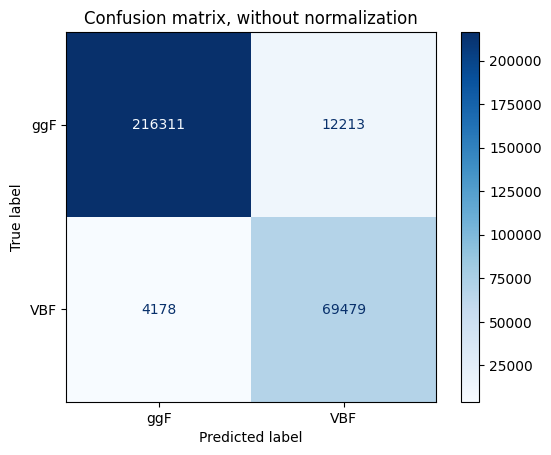

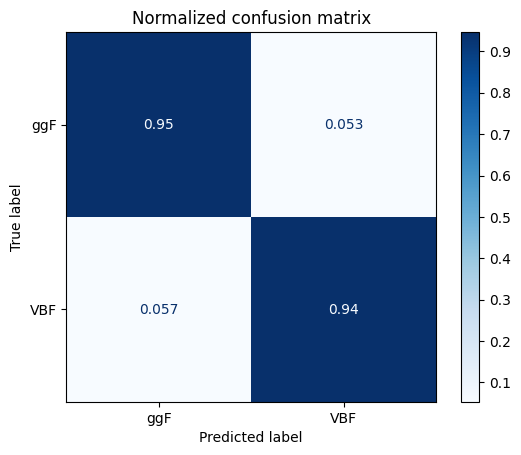

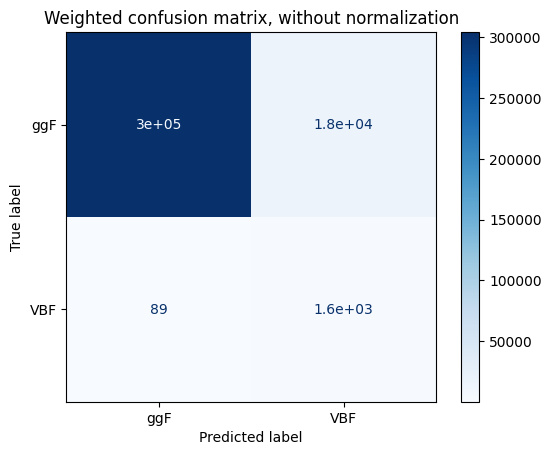

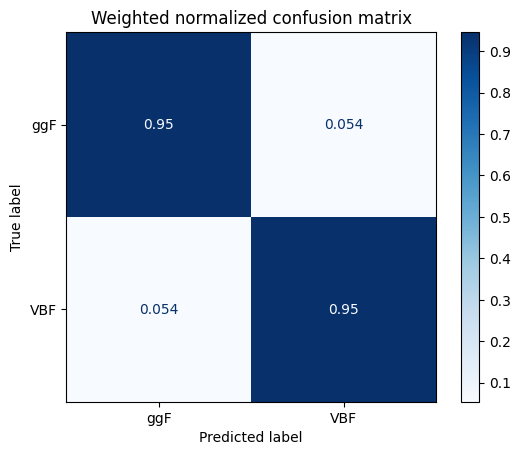

In [23]:
division_cut = best_w_cut
y_class = y_pred_test.copy()
# y_class_bg = y_pred_test_bg.copy()
y_class[y_pred_test>division_cut]=1.0
y_class[y_pred_test<=division_cut]=0.0
# y_class_bg[y_pred_test_bg>division_cut]=1.0
# y_class_bg[y_pred_test_bg<=division_cut]=0.0
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None, None),
                  ("Normalized confusion matrix", 'true', None),
                  ("Weighted confusion matrix, without normalization", None, w_test),
                  ("Weighted normalized confusion matrix", 'true', w_test)]
for title, normalize, w in titles_options:
    # disp = plot_confusion_matrix(reg, X_test, Y_test,
    #                              #display_labels=class_names,
    #                              cmap=plt.cm.Blues,
    #                              normalize=normalize)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_class,
                                 normalize=normalize, 
                                 sample_weight=w,
                                 display_labels = ["ggF","VBF"],
                                 cmap=plt.cm.Blues)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
del title, normalize, w
# disp_bg = ConfusionMatrixDisplay.from_predictions(y_test_bg, y_class_bg,
                                #  normalize=None, 
                                #  sample_weight=w_test_bg,
                                #  display_labels = ["ggF","VBF"],
                                #  cmap=plt.cm.Blues)
# print(disp_bg.confusion_matrix/np.sum(w_test_bg))
plt.show()

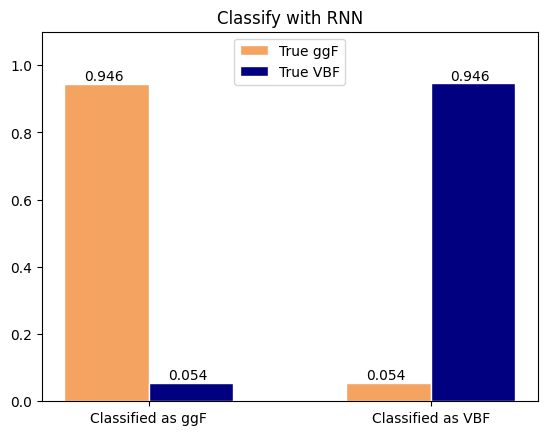

In [24]:
barWidth = 0.3
xh = 0.08
labels = ["Classified as ggF", "Classified as VBF"]
ggf_as_ggf_bdt = disp.confusion_matrix[0,0]
ggf_as_vbf_bdt = disp.confusion_matrix[0,1]
vbf_as_ggf_bdt = disp.confusion_matrix[1,0]
vbf_as_vbf_bdt = disp.confusion_matrix[1,1]
# bg_as_vbf_bdt = disp_bg.confusion_matrix[0,1]/w_true_bg
# bg_as_ggf_bdt = disp_bg.confusion_matrix[0,0]/w_true_bg
bars1 = [ggf_as_ggf_bdt, ggf_as_vbf_bdt]
bars2 = [vbf_as_ggf_bdt, vbf_as_vbf_bdt]
# bars3 = [bg_as_ggf_bdt, bg_as_vbf_bdt]
title = "Classify with RNN"
plot_name = "bdt_cut_barplot"
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
# r3 = [x + barWidth for x in r2]

# Make the plot
plt.figure()
plt.bar(r1, bars1, color='sandybrown', width=barWidth, edgecolor='white', label='True ggF')
plt.bar(r2, bars2, width=barWidth, color="navy", edgecolor='white', label='True VBF')
# plt.bar(r3, bars3, width=barWidth, color='firebrick', edgecolor='white', label='Background')
plt.title(title)
# Add xticks on the middle of the group bars
# plt.xlabel('Classification', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], labels)
bars11 = np.concatenate((bars1,bars2))#,bars3))
r11 = np.concatenate((r1,r2))#,r3))
plt.ylim(0,1.1)
for j, v in enumerate(bars11):
    if v > 0.95:
        plt.text(r11[j] - xh, v - 0.05, f"{v:.3f}")
    else:
        plt.text(r11[j] - xh, v + 0.01, f"{v:.3f}")

# Create legend & Show graphic
plt.legend(loc='upper center')

In [25]:
y_extra = np.zeros(len(b_e_less_2jets))
y_class_2 = np.concatenate((y_class, y_extra))
w_test_2 = np.concatenate((w_test, w_extra))
y_test_2 = np.concatenate((y_test,y_extra))

Confusion matrix, without normalization
[[608314  12213]
 [  4178  69479]]
Normalized confusion matrix
[[0.98031834 0.01968166]
 [0.05672238 0.94327762]]
Weighted confusion matrix, without normalization
[[8.93330769e+05 1.75420249e+04]
 [8.89503742e+01 1.55824244e+03]]
Weighted normalized confusion matrix
[[0.98074152 0.01925848]
 [0.05400119 0.94599881]]


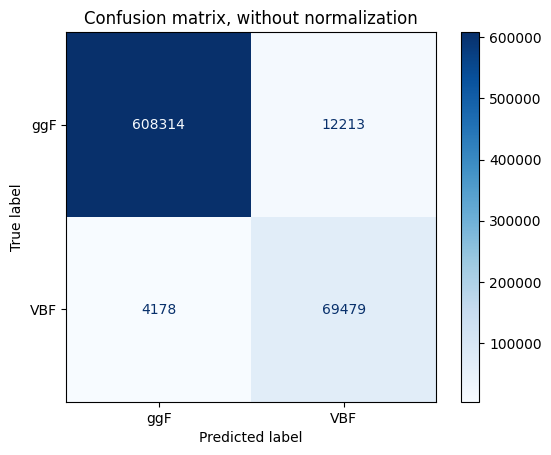

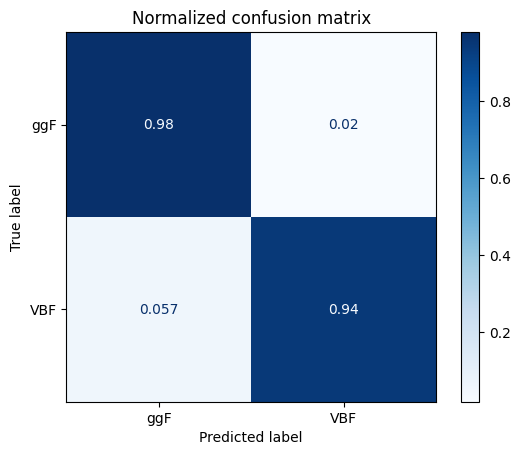

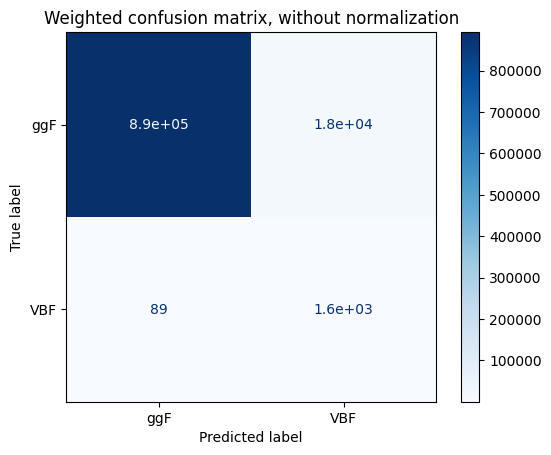

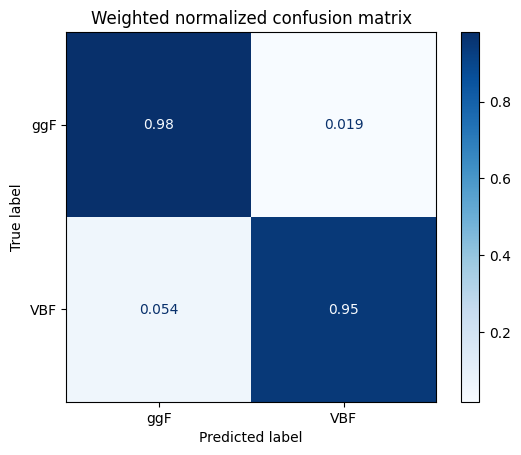

In [26]:
# Adding pre classified ggF events
titles_options = [("Confusion matrix, without normalization", None, None),
                  ("Normalized confusion matrix", 'true', None),
                  ("Weighted confusion matrix, without normalization", None, w_test_2),
                  ("Weighted normalized confusion matrix", 'true', w_test_2)]
for title, normalize, w in titles_options:
    # disp = plot_confusion_matrix(reg, X_test, Y_test,
    #                              #display_labels=class_names,
    #                              cmap=plt.cm.Blues,
    #                              normalize=normalize)
    disp = ConfusionMatrixDisplay.from_predictions(y_test_2, y_class_2,
                                 normalize=normalize, 
                                 sample_weight=w,
                                 display_labels = ["ggF","VBF"],
                                 cmap=plt.cm.Blues)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
del title, normalize, w
# disp_bg = ConfusionMatrixDisplay.from_predictions(y_test_bg, y_class_bg,
                                #  normalize=None, 
                                #  sample_weight=w_test_bg,
                                #  display_labels = ["ggF","VBF"],
                                #  cmap=plt.cm.Blues)
# print(disp_bg.confusion_matrix/np.sum(w_test_bg))
plt.show()

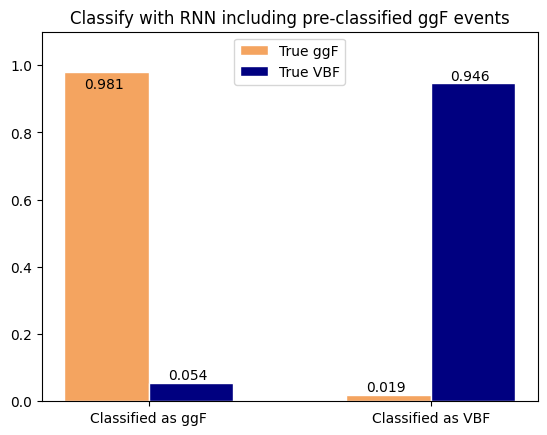

In [27]:
barWidth = 0.3
xh = 0.08
labels = ["Classified as ggF", "Classified as VBF"]
ggf_as_ggf_bdt = disp.confusion_matrix[0,0]
ggf_as_vbf_bdt = disp.confusion_matrix[0,1]
vbf_as_ggf_bdt = disp.confusion_matrix[1,0]
vbf_as_vbf_bdt = disp.confusion_matrix[1,1]
# bg_as_vbf_bdt = disp_bg.confusion_matrix[0,1]/w_true_bg
# bg_as_ggf_bdt = disp_bg.confusion_matrix[0,0]/w_true_bg
bars1 = [ggf_as_ggf_bdt, ggf_as_vbf_bdt]
bars2 = [vbf_as_ggf_bdt, vbf_as_vbf_bdt]
# bars3 = [bg_as_ggf_bdt, bg_as_vbf_bdt]
title = "Classify with RNN including pre-classified ggF events"
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
# r3 = [x + barWidth for x in r2]

# Make the plot
plt.figure()
plt.bar(r1, bars1, color='sandybrown', width=barWidth, edgecolor='white', label='True ggF')
plt.bar(r2, bars2, width=barWidth, color="navy", edgecolor='white', label='True VBF')
# plt.bar(r3, bars3, width=barWidth, color='firebrick', edgecolor='white', label='Background')
plt.title(title)
# Add xticks on the middle of the group bars
# plt.xlabel('Classification', fontweight='bold')
plt.xticks([r + barWidth/2 for r in range(len(bars1))], labels)
bars11 = np.concatenate((bars1,bars2))#,bars3))
r11 = np.concatenate((r1,r2))#,r3))
plt.ylim(0,1.1)
for j, v in enumerate(bars11):
    if v > 0.95:
        plt.text(r11[j] - xh, v - 0.05, f"{v:.3f}")
    else:
        plt.text(r11[j] - xh, v + 0.01, f"{v:.3f}")

# Create legend & Show graphic
plt.legend(loc='upper center')